In [1]:
import time

# data processing library
import numpy as np
import pandas as pd
from functools import reduce
import collections

# data visualization library  
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")


# Background

Boehringer Ingelheim has been working on a multi channel customer engagement approach as part of their strategy. 

As such, email communication has been identified as a viable channel in which to communicate with physicians.

As customer centricity is a focus for BI, the online communication should be tailored to the physician‘s preferences and requirements.

BI has been working with physicians to obtain their consent to receiving communication from the company via email. 

This is mainly done by having the customer facing team ask the physician for their consent during face to face visits.

The Brand Team has created compliance approved promotional materials for online communcation. 

A campaign cycle has been completed using a mix of face to face and email communication and data has been collected to look at the email activity of physicians.


# Task

In the data provided to you, there is record of the email communication sent to physicians who have opted in. 

As email communication is regulated by law, BI can only contact physicians via this channel if an opt in is available.

You will also find the categorization of email addresses of customers in private practice or in a clinic, which indicates the preferred email address of the physician with which they would like BI to use.

Based on the needs of the Brand Team, analyze the data and prepare a management presentation to provide recommendations for optimizing the email communication approach including recommendations on how to measure the success of subsequent email campaigns.

Your presentation should be no longer than 15 minutes. The audience will be a mixed group of brand team members including analysts.

You are welcome to use any presentation medium.



# Read Data

## Description of the fields

- HCP_ID
    - HCP0001018487

    - Physician's ID (at least 1 record per person, multiple records for promotions and multiple emails)

    - (diverse)


- ACCOUNT_TYPE
    - Account type

    - Specifies the account type of the customer's email address.
    
    - Private, Klinic (clinic), Nicht eindeutig (ambiguous)
    
 
- EMAIL_ID
    - ID1
    - Email ID that can be used to uniquely identify an email. The same emails have the same ID
    -  ID1, ID2,....ID120


- DELIVERY_STATUS
    - sent
    - Delivery Status of email
    - Sent, opened, clicked, failed


- PRODUKT
    - Produkt1
    - Product Name
    - Produkt 1, Produkt 2,...Produkt 6
 
 
- DATUM_ID
    - 20190109
    - Email activity date, format YYYYMMDD (can be NULL)
    - (diverse)
  
  
- DAY
    - 09.01.2019 21:00
    - Date and time of the email activity, format DD.MM.YYYY HH: MM (can be NULL) The times are always rounded to the hour
    - (diverse)






In [50]:
df_account = pd.read_excel('Account_Cluster.xlsx')


In [51]:
def get_hcp_id(row):
    return row['HCP_ID;ACCOUNT_TYPE'].split(';')[0]

def get_account_type(row):
    return row['HCP_ID;ACCOUNT_TYPE'].split(';')[1]

df_account['HCP_ID'] = df_account.apply(get_hcp_id, axis=1)
df_account['ACCOUNT_TYPE'] = df_account.apply(get_account_type, axis=1)
df_account.drop(columns=['HCP_ID;ACCOUNT_TYPE'], inplace=True)


In [52]:
df_account

HCP_ID     ACCOUNT_TYPE
0      HCP0001018487          private
1      HCP0001006058          private
2      HCP0001013999          private
3      HCP0001002071          private
4      HCP0001008572          private
...              ...              ...
17040  HCP0001014874           klinik
17041  HCP0001005716  nicht eindeutig
17042  HCP0001005735  nicht eindeutig
17043  HCP0001005065           praxis
17044  HCP0001014715  nicht eindeutig

[17045 rows x 2 columns]

In [56]:
df_account.shape

(17045, 2)

In [53]:
df_email_performance = pd.read_csv('EMail_Performance.csv', delimiter=';')


In [54]:
df_email_performance['DATE'] = pd.to_datetime(df_email_performance['DATUM_ID'], format="%Y%m%d")
df_email_performance['DATE_TIME'] = pd.to_datetime(df_email_performance['DAY'], format="%d.%m.%Y %H:%M")

# df_email_performance['DATE_TIME'].dt.hour.unique()


In [55]:
df_email_performance.head()


HCP_ID EMAIL_ID DELIVERY_STATUS    PRODUKT  DATUM_ID  \
0  HCP0001001023      ID1            sent  Produkt 1  20190109   
1  HCP0001001024      ID2          opened  Produkt 1  20181024   
2  HCP0001001025      ID3            sent  Produkt 2  20181130   
3  HCP0001001026      ID4          opened  Produkt 3  20181119   
4  HCP0001001027      ID5          opened  Produkt 4  20181213   

                DAY       DATE           DATE_TIME  
0  09.01.2019 21:00 2019-01-09 2019-01-09 21:00:00  
1  24.10.2018 01:00 2018-10-24 2018-10-24 01:00:00  
2  30.11.2018 13:00 2018-11-30 2018-11-30 13:00:00  
3  19.11.2018 14:00 2018-11-19 2018-11-19 14:00:00  
4  13.12.2018 14:00 2018-12-13 2018-12-13 14:00:00

In [57]:
df_email_performance.shape


(359777, 8)

In [59]:
len(df_email_performance['HCP_ID'].unique())


18841

In [60]:
len(df_account['HCP_ID'].unique())


17045

In [61]:
df = pd.merge(df_account, df_email_performance, on='HCP_ID', how='right')


In [62]:
df.shape


(359777, 9)

In [63]:
df.head()


HCP_ID ACCOUNT_TYPE EMAIL_ID DELIVERY_STATUS    PRODUKT  DATUM_ID  \
0  HCP0001018487      private     ID51            sent  Produkt 1  20170307   
1  HCP0001006058      private     ID11            sent  Produkt 6  20180516   
2  HCP0001006058      private     ID26          opened  Produkt 4  20181212   
3  HCP0001006058      private     ID26          opened  Produkt 4  20181213   
4  HCP0001006058      private     ID16          opened  Produkt 5  20181113   

                DAY       DATE           DATE_TIME  
0  07.03.2017 11:00 2017-03-07 2017-03-07 11:00:00  
1  16.05.2018 14:00 2018-05-16 2018-05-16 14:00:00  
2  12.12.2018 15:00 2018-12-12 2018-12-12 15:00:00  
3  13.12.2018 17:00 2018-12-13 2018-12-13 17:00:00  
4  13.11.2018 19:00 2018-11-13 2018-11-13 19:00:00

# Exploratory Data Analysis (EDA)



In [71]:
def plot_pie_bar(df, col, title=''):
    f,ax=plt.subplots(1, 2, figsize=(20, 8))
    
    df[col].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(col)
    ax[0].set_ylabel('')
    
    sns.countplot(col, order = df[col].value_counts().index, data=df, ax=ax[1])
    ax[1].set_title(col)
    
    plt.title(title)
    plt.show()
    
    return 


In [64]:
df.columns


Index(['HCP_ID', 'ACCOUNT_TYPE', 'EMAIL_ID', 'DELIVERY_STATUS', 'PRODUKT',
       'DATUM_ID', 'DAY', 'DATE', 'DATE_TIME'],
      dtype='object')

## ACCOUNT_TYPE


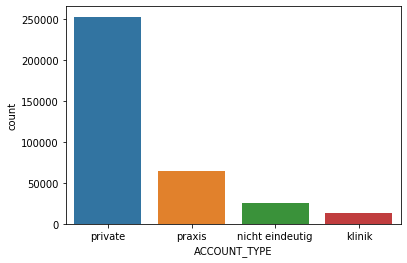

In [65]:
ax = sns.countplot(df['ACCOUNT_TYPE'], label="Count")


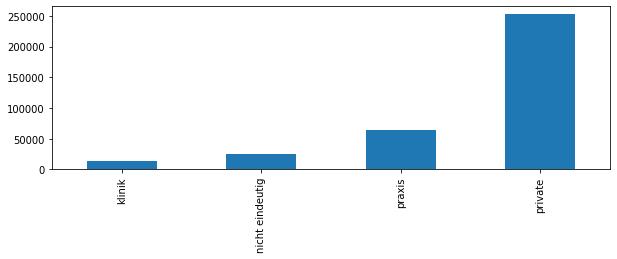

In [69]:
df['ACCOUNT_TYPE'].value_counts().sort_index().plot(kind='bar', figsize=(10, 3))


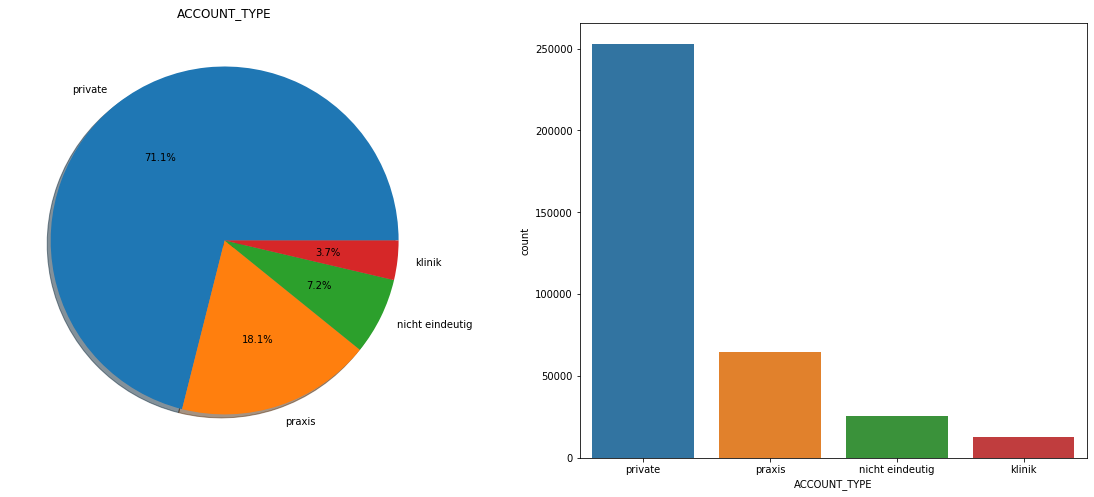

In [72]:
plot_pie_bar(df, 'ACCOUNT_TYPE')


## DELIVERY_STATUS


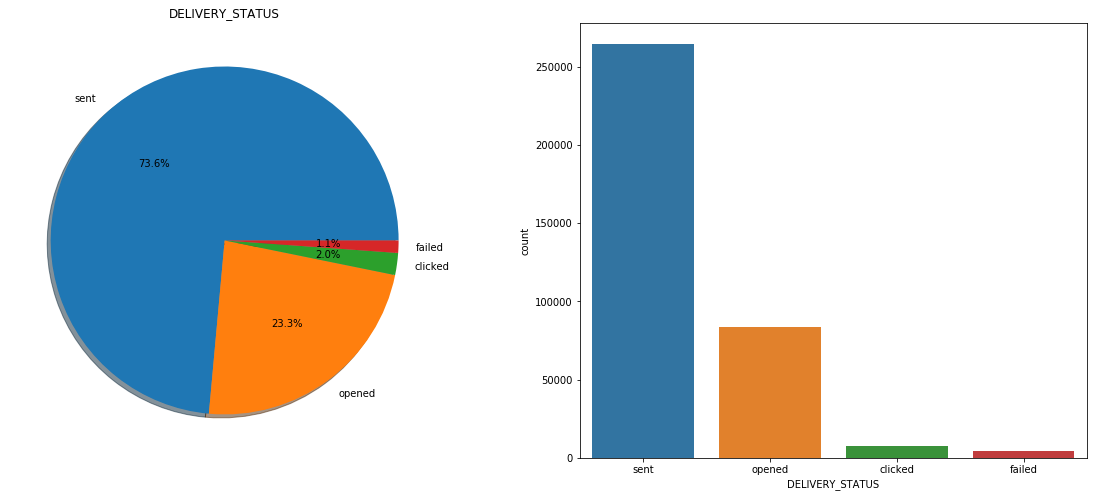

In [73]:
plot_pie_bar(df, 'DELIVERY_STATUS')


## PRODUKT


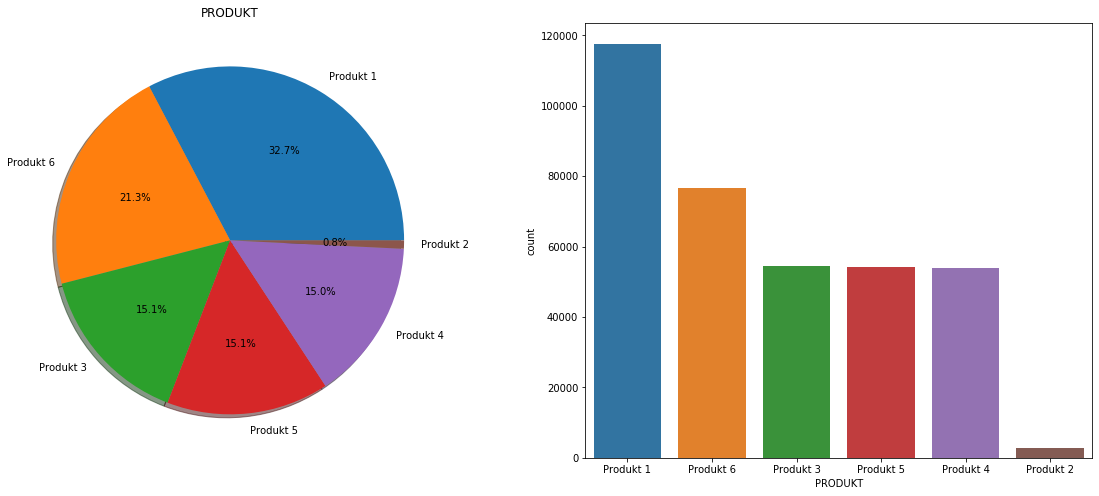

In [74]:
plot_pie_bar(df, 'PRODUKT')


## DATE_TIME

In [75]:
df['TIME'] = df['DATE_TIME'].dt.hour


In [77]:
df.head()

HCP_ID ACCOUNT_TYPE EMAIL_ID DELIVERY_STATUS    PRODUKT  DATUM_ID  \
0  HCP0001018487      private     ID51            sent  Produkt 1  20170307   
1  HCP0001006058      private     ID11            sent  Produkt 6  20180516   
2  HCP0001006058      private     ID26          opened  Produkt 4  20181212   
3  HCP0001006058      private     ID26          opened  Produkt 4  20181213   
4  HCP0001006058      private     ID16          opened  Produkt 5  20181113   

                DAY       DATE           DATE_TIME  TIME  
0  07.03.2017 11:00 2017-03-07 2017-03-07 11:00:00    11  
1  16.05.2018 14:00 2018-05-16 2018-05-16 14:00:00    14  
2  12.12.2018 15:00 2018-12-12 2018-12-12 15:00:00    15  
3  13.12.2018 17:00 2018-12-13 2018-12-13 17:00:00    17  
4  13.11.2018 19:00 2018-11-13 2018-11-13 19:00:00    19

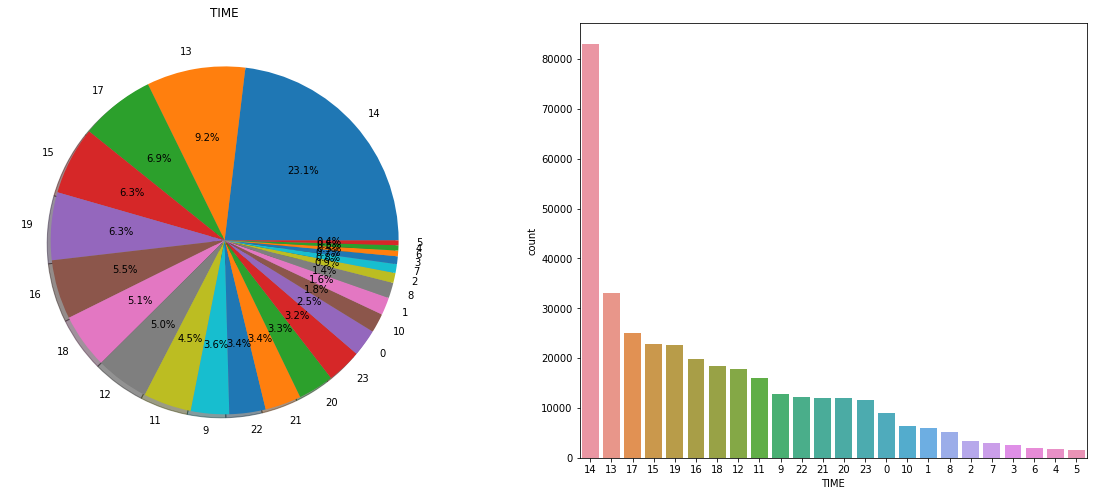

In [78]:
plot_pie_bar(df, 'TIME')


In [80]:
def get_time_group(time):
    if 0 <= time <= 7:
        return '0 - 7'
    elif 7 < time <= 12:
        return '7 - 12'
    elif 12 < time <= 13:
        return '12 - 13'
    elif 13 < time <= 18:
        return '13 - 18'
    else:
        return '18 - 0'
    

In [82]:
df['TIME_GROUP'] = df['TIME'].apply(get_time_group)


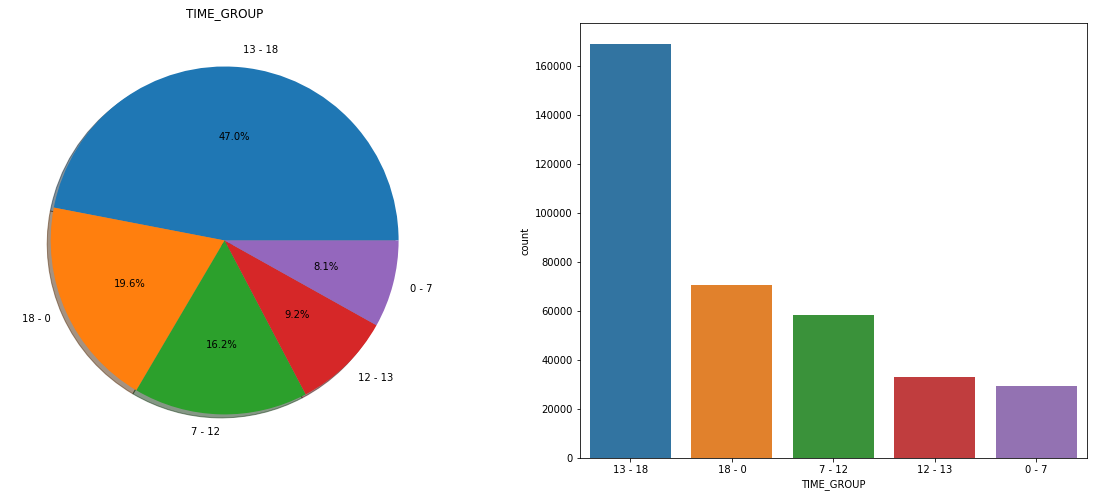

In [83]:
plot_pie_bar(df, 'TIME_GROUP')


In [90]:
df['YEAR'] = df['DATE_TIME'].dt.year
df['MONTH'] = df['DATE_TIME'].dt.month
df['DAY_OF_WEEK'] = df['DATE_TIME'].dt.dayofweek


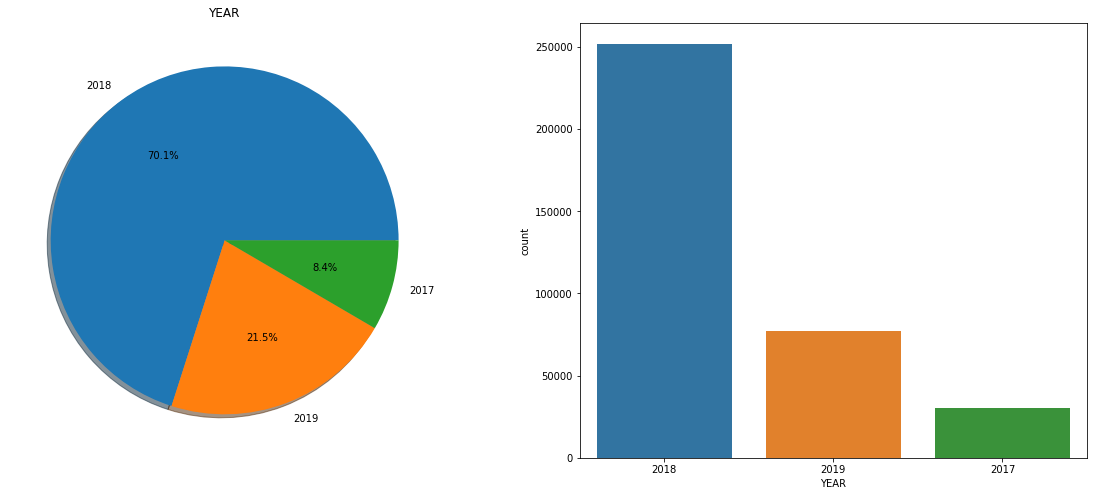

In [91]:
plot_pie_bar(df, 'YEAR')


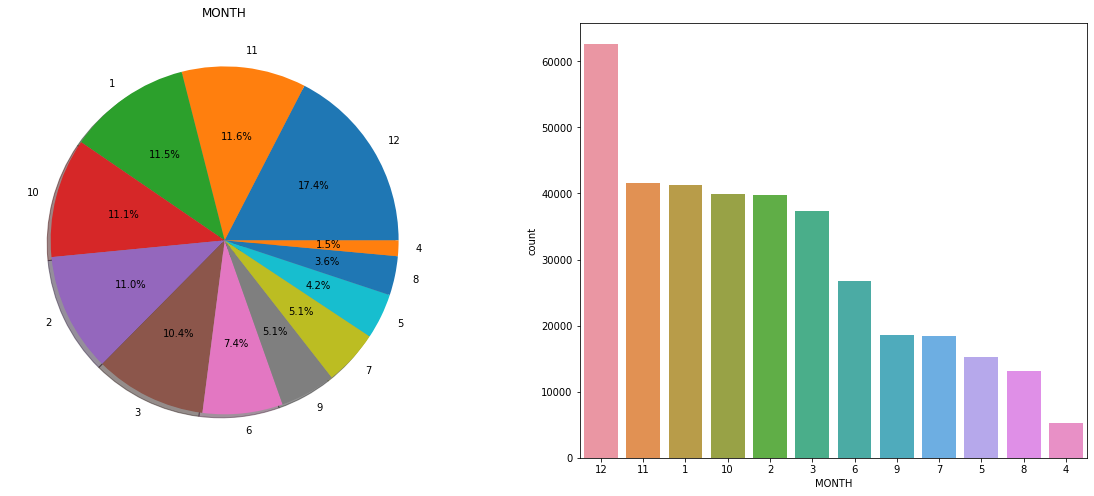

In [92]:
plot_pie_bar(df, 'MONTH')


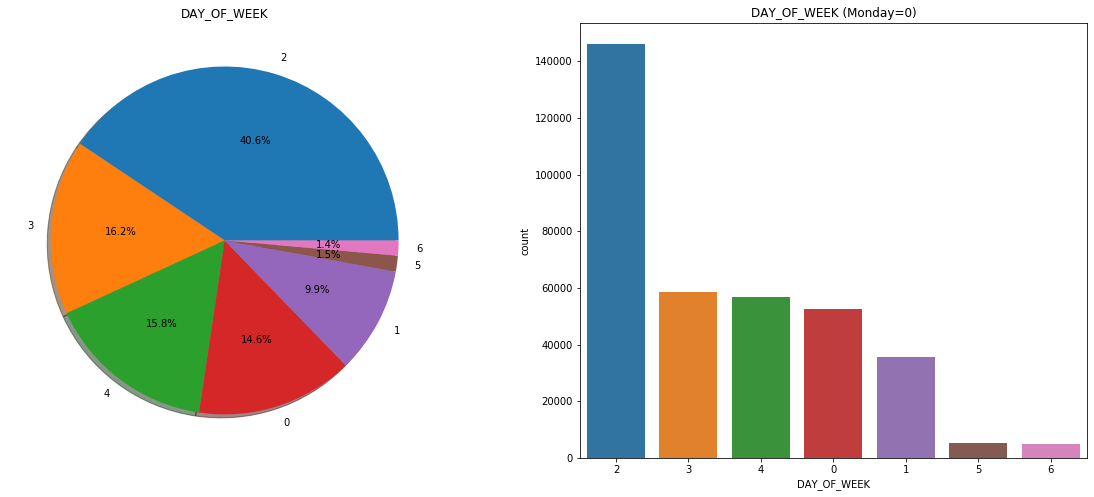

In [95]:
plot_pie_bar(df, 'DAY_OF_WEEK', title='DAY_OF_WEEK (Monday=0)')


## HCP_ID

- HCP0001018487

- Physician's ID (at least 1 record per person, multiple records for promotions and multiple emails)

- (diverse)


In [98]:
len(df['HCP_ID'].unique())


18841

In [106]:
group_email = df.groupby(['HCP_ID'])['EMAIL_ID'].apply(set).reset_index(name='set_EMAIL_ID')


In [107]:
group_email


HCP_ID                                       set_EMAIL_ID
0      HCP0001001023  {ID6, ID1, ID2, ID35, ID26, ID50, ID7, ID14, I...
1      HCP0001001024  {ID6, ID1, ID5, ID2, ID35, ID12, ID50, ID7, ID...
2      HCP0001001025                                         {ID8, ID3}
3      HCP0001001026                {ID46, ID32, ID4, ID33, ID59, ID83}
4      HCP0001001027  {ID43, ID23, ID22, ID6, ID15, ID5, ID2, ID58, ...
...              ...                                                ...
18836  HCP0001019859                                             {ID11}
18837  HCP0001019860                                              {ID7}
18838  HCP0001019861                                             {ID11}
18839  HCP0001019862                                             {ID63}
18840  HCP0001019863                                             {ID11}

[18841 rows x 2 columns]

In [108]:
def get_nb_emails(row):
    return len(row['set_EMAIL_ID'])
    
group_email['NB_EMAILS'] = group_email.apply(get_nb_emails, axis=1)
    

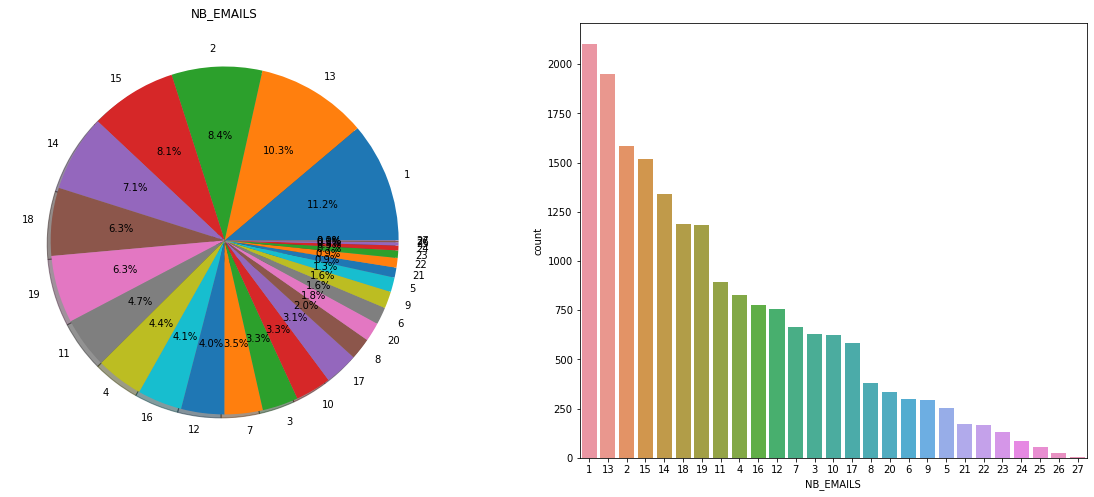

In [109]:
plot_pie_bar(group_email, 'NB_EMAILS')


## EMAIL_ID
    - ID1
    - Email ID that can be used to uniquely identify an email. The same emails have the same ID
    - ID1, ID2,....ID120



In [110]:
len(df['EMAIL_ID'].unique())


120